In [1]:
from urllib import request
import zipfile
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error

### 1. Get dataset

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### 2. Prepare error metrics: RMSE
Your Task:
1. Prepare 2 functions that will calculate the goodness of fit: RMSE and HR@n
2. RMSE:
$RMSE(R,\hat{R})=\sqrt{1/n \sum{(r - \hat{r})^2}}$ <br/>
$n\  - \text{# ratings in Y}$ <br/>
$R\  - \text{ground true ratings}$ <br/>
$\hat{R}\ - \text{predictions of your model}$ <br/>

In [9]:
def rmse(R,R_hat,index):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): rank 2 matrix of (ground) true ratings
         R_hat (np.array): rank 2 matrix of ratings' predictions R.shape = R_hat.shape
         index (np.array): index of R and R_hat for which RMSE needs to be calculated
    returns:
         RMSE value
        
    """
    #YOUR TASK: implement RMSE
    X = np.multiply((R-R_hat), index)
    Y = np.sum(np.multiply(X,X))
    Z= np.sum(index)
    return np.sqrt(Y / Z)

### 3. Prepare error metrics HR@n (please solve after you implement MF with ALS)

Your task: write a function that calculates HR@n

HR(u)@n for a single user u is calculated when the number of recommended items for that user is n. If out of n recommended items m (m<=n) were consumed by user then:

#### $HR@n(u) = \frac{m}{n}$ <br/>

Overall HR@n is just an average over all users:
#### $HR@n = \frac{1}{n_u} \sum{\frac{m}{n}}$ <br/>
 
be careful with caveats with HR!

In [10]:
def HR_at_n(R,R_hat,R_exclude,n=10):
    """
    Calculates RMSE between true ratings R and ratings estimations R_hat for index.
    params:
         R (np.array): rank 2 matrix of (ground) true ratings
         R_hat (np.array): rank 2 matrix of ratings' predictions R.shape = R_hat.shape
         R_exclude (np.array): rank 2 matrix of ratings to be excluded i.e. if R_exclude[u,i]>0 then item i for user u has to be excluded from HR calculation (e.g. it was used for training)
         n (int): length of recommendation
    returns:
         RMSE value
        
    """
    
    R_hat = copy.copy(R_hat)
    exclude_items_per_user = np.sum(R_exclude>0, axis=1)
    R_hat[R_exclude>0] = -np.inf
    pred_items =  np.argsort(-R_hat, axis=1)
    true_items = np.argsort(-R, axis=1)
    exclude_items_cnt = np.sum(R_exclude>0, axis=1)
    test_items_cnt = np.sum(R>0, axis=1)
    hr_total = 0
    for user_id in range(pred_items.shape[0]):
        min_end = min(n, pred_items.shape[1]-exclude_items_cnt[user_id])
        pred_items_for_user = pred_items[user_id,:min_end]
        propper_itemscnt_for_user = np.sum(np.in1d(pred_items_for_user, true_items[user_id,:test_items_cnt[user_id]]))
        if test_items_cnt[user_id]>0:
            hr_for_user = propper_itemscnt_for_user/min(n, test_items_cnt[user_id])
            hr_total += hr_for_user
    
    hr_total /= np.shape(R)[0]
    return hr_total




### 4. Main part: iplementation of ALS

Your task: implement a ALS MF recommender. This is iterative algorithm and MF_ALS class implements it.
#### 1. We will factorise rating matrix R so that $R\approx \hat{R}= XY^T$ , 
#### 2. Every step of this iteration calculates X and Y which are in fact embeedings for users (X) and items (Y) and there will be n_iters iterations
#### 3. $X \in R^{n_u\ x\ \text{n_factors}}$ $Y \in R^{n_i\ x\ \text{n_factors}}$ X, Y can be initialised uniformlly [0,1]
#### 4. We want it to be a regularised version of ALR (reg>0), but you can start without it for simplicity
#### 5. After every iteration we want to log the RMSE and HR@n using functions that you have developed above


In [11]:
class MF_ALS:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test,n=10):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        # YOUR TASKS 0: initialise X, Y (user and items factors)
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_rmse_record  = []
        self.train_rmse_record = []  
        self.test_hr = []
        self.train_hr = []
        self.hr_n = n 
        for _ in range(self.n_iters):
            # YOUR TASKS 1: call _als_step to get updated values for user and item embeeding tables
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors)       
            # YOUR TASKS 2: get predictions i.e. R_hat
            predictions = self.predict()
            test_rmse = self.compute_rmse(test, predictions)
            train_rmse = self.compute_rmse(train, predictions)
            test_hr = self.compute_hr_at_n(test,predictions,train,n)
            train_hr = self.compute_hr_at_n(train,predictions,np.zeros_like(train),n)
            self.test_rmse_record.append(test_rmse)
            self.train_rmse_record.append(train_rmse)
            self.test_hr.append(test_hr)
            self.train_hr.append(train_hr)
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        # YOUR TASKS 1.1: callculate update for X/Y depending on parameters. WHITEBOARD FIRST!
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        # YOUR TASKS 2.2: get predictions i.e. R_hat
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_rmse(R, R_hat):
        """ignore zero terms prior to comparing the mse"""
        rmse_val = rmse(R,R_hat,R>=1)
        return rmse_val
    
    @staticmethod
    def compute_hr_at_n(R,R_hat,R_exclue,n):
        return HR_at_n(R,R_hat,R_exclue,n)


In [12]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 1
    
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(model.test_rmse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_rmse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('RMSE')
    plt.legend(loc = 'best')

    plt.subplot(1, 2, 2)
    plt.plot(model.test_hr, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_hr, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('HR@{}'.format(model.hr_n))
    plt.legend(loc = 'best')

    plt.show()

#### 5. Time for test!

1. What are HyperParams of this algorithm?
2. Can you find best ones?
3. What are conclussions?

Train RMSE after fold 1: 1.8782415615526984
Test RMSE after fold 1: 3.151144893387383
Train HR@10 after fold 1: 0.9221199649884673
Test HR@10 after fold 1: 0.21866468043562418


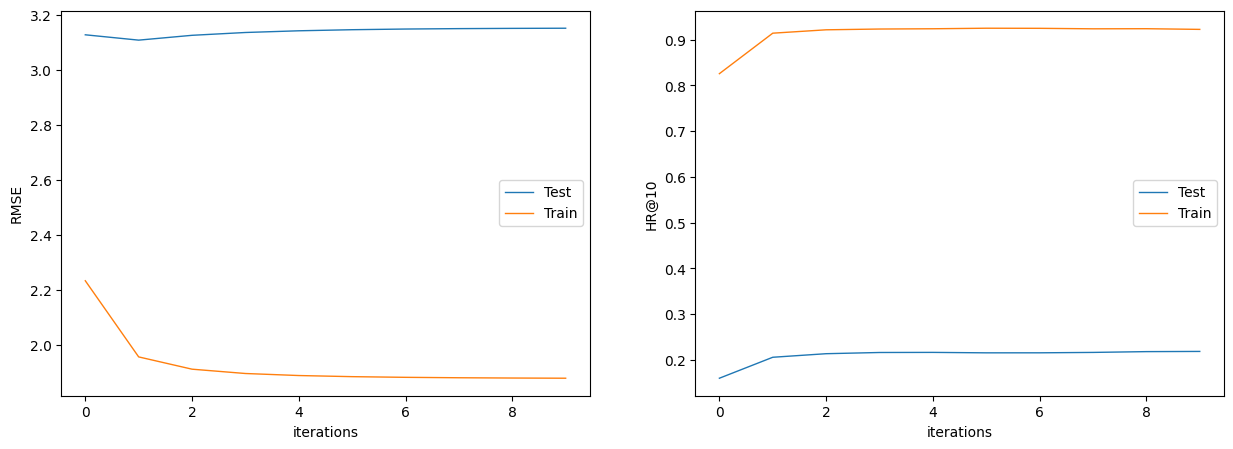

Train RMSE after fold 2: 1.8973089746205958
Test RMSE after fold 2: 3.076114861487544
Train HR@10 after fold 2: 0.9301284317190964
Test HR@10 after fold 2: 0.2662833072430103


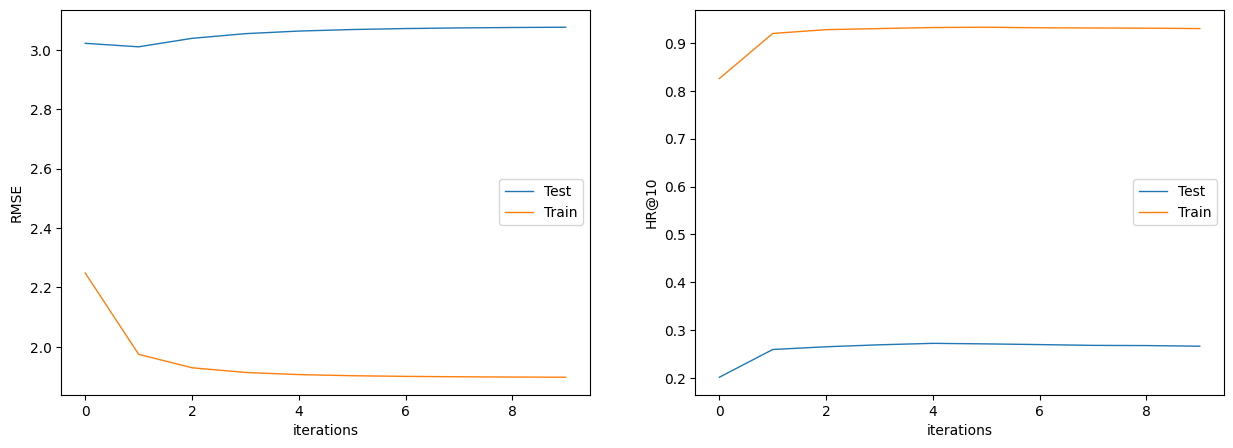

Train RMSE after fold 3: 1.9008151029414502
Test RMSE after fold 3: 3.00745123799099
Train HR@10 after fold 3: 0.9268292682926805
Test HR@10 after fold 3: 0.3216890538470604


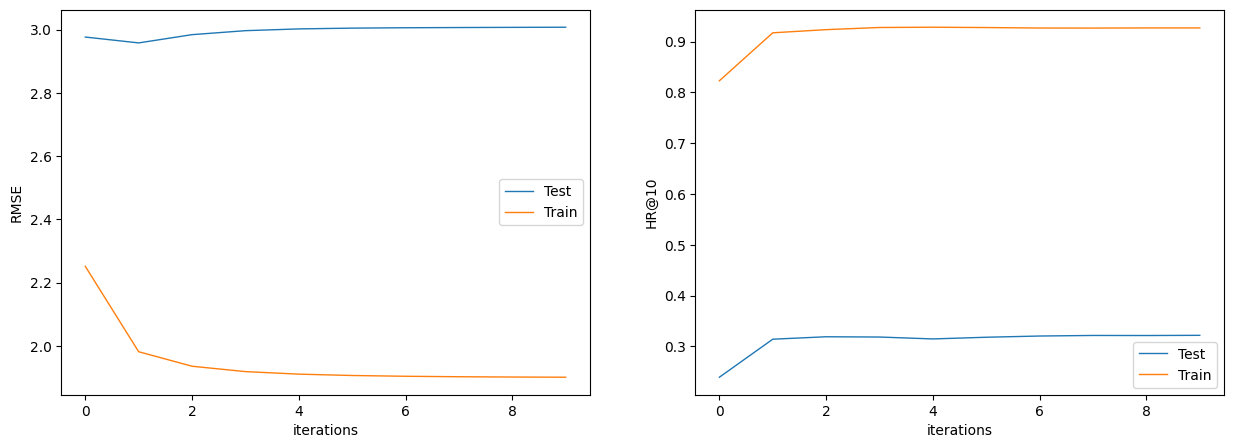

Train RMSE after fold 4: 1.8986725730742304
Test RMSE after fold 4: 3.016406986245678
Train HR@10 after fold 4: 0.9243965560773588
Test HR@10 after fold 4: 0.3247184769984347


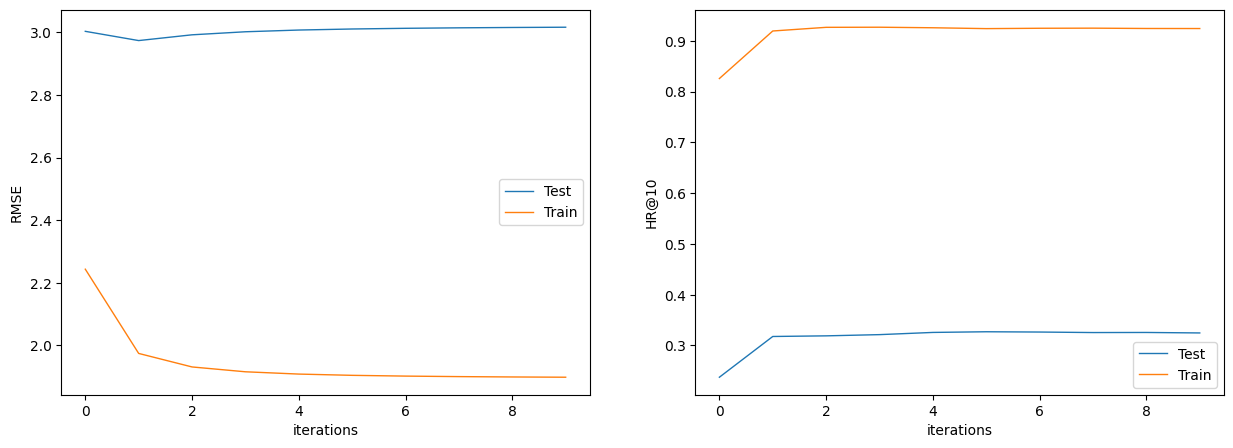

Train RMSE after fold 5: 1.885447245926151
Test RMSE after fold 5: 3.059302960551315
Train HR@10 after fold 5: 0.9229342355535329
Test HR@10 after fold 5: 0.3282823309599552


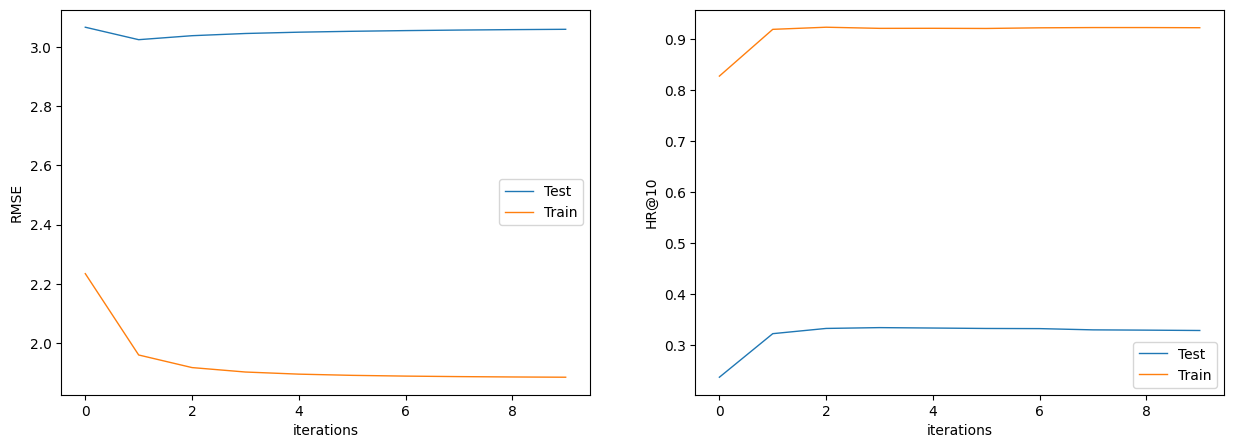

In [13]:
for fold in range(1,6):
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    #YOUR TASK: get train and test R, fit the model, plot learning curve
    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    als = MF_ALS(n_iters = 10, n_factors = 64, reg = 0)
    als.fit(train_ratings_matrix, test_ratings_matrix)
    print("Train RMSE after fold {}: {}".format(fold, als.compute_rmse(train_ratings_matrix, als.predict())))
    print("Test RMSE after fold {}: {}".format(fold, als.compute_rmse(test_ratings_matrix, als.predict())))
    print("Train HR@{} after fold {}: {}".format(als.hr_n, fold, als.compute_hr_at_n(train_ratings_matrix, als.predict(), np.zeros_like(train_ratings_matrix), als.hr_n)))
    print("Test HR@{} after fold {}: {}".format(als.hr_n, fold, als.compute_hr_at_n(test_ratings_matrix, als.predict(), train_ratings_matrix, als.hr_n)))

    plot_learning_curve(als)

#### 6. How to modify the above code so that:

We would have ratings {0,1} only instead of {1,2,3,4,5}. What will it change?

## Your Task:
Find appropriate HyperParams of this simple alrogithm by Cross Validation.

In [14]:
def grid_search(n_iters, n_factors, reg):
    best_hr_10 = float('-inf')
    best_params = {}
    for n_iter in n_iters:
        for n_factor in n_factors:
            for reg_val in reg:
                print("===================================")
                print("Testing hyperparameters:")
                print("Number of iterations: ", n_iter)
                print("Number of factors: ", n_factor)
                print("Regularization value: ", reg_val)
                print("===================================")
                hr_n10_folds = []
                for fold in range(1, 6):
                    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, 
                                        names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)
                    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, 
                                       names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)
                    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'], 
                                                                categories=[i for i in range(1, 943 + 1)]),
                                                                columns=pd.Categorical(train['item_id'], 
                                                                categories=[i for i in range(1, 1682 + 1)]),
                                                                values=train['rating'], 
                                                                aggfunc=np.sum, dropna=False).fillna(0).values)
                    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'], 
                                                               categories=[i for i in range(1, 943 + 1)]),
                                                               columns=pd.Categorical(test['item_id'], 
                                                               categories=[i for i in range(1, 1682 + 1)]),
                                                               values=test['rating'], 
                                                               aggfunc=np.sum, dropna=False).fillna(0).values)
                    als = MF_ALS(n_iters=n_iter, n_factors=n_factor, reg=reg_val)
                    als.fit(train_ratings_matrix, test_ratings_matrix)
                    preds = als.predict()
                    rmse = als.compute_rmse(test_ratings_matrix, preds)
                    hr_10 = als.compute_hr_at_n(test_ratings_matrix, preds, train_ratings_matrix, n=10)
                    hr_n10_folds.append(hr_10)
                    print("Fold: ", fold)
                    print("RMSE: ", rmse)
                    print("hr@10: ", hr_10)
                avg_hr_10 = np.mean(hr_n10_folds)
                print("===================================")
                print("Average hr@10 for this parameter combination: ", avg_hr_10)
                print()
                if avg_hr_10 > best_hr_10:
                    best_hr_10 = avg_hr_10
                    best_params = {'n_iters': n_iter, 'n_factors': n_factor, 'reg': reg_val}
                    print("===================================")
                    print("New best found!")
                    print("hr@10: ", best_hr_10)
                    print("Best hyperparameters: ", best_params)
                    print("===================================")
    print("===================================")
    print("Grid search complete.")
    print("Best hr@10 found: ", best_hr_10)
    print("Best hyperparameters: ", best_params)
    print("===================================")
    return best_params

In [15]:
n_iters = [10, 15, 20, 25, 30]
n_factors = [10, 50, 100]
reg = [0.001, 0.01, 0.1, 1]

best_params = grid_search(n_iters, n_factors, reg)
# print("Best Hyperparameters:", best_params)

Testing hyperparameters:
Number of iterations:  10
Number of factors:  10
Regularization value:  0.001
Fold:  1
RMSE:  2.879779798421109
hr@10:  0.247762965207292
Fold:  2
RMSE:  2.7272962663448888
hr@10:  0.31191991112457734
Fold:  3
RMSE:  2.689872609230706
hr@10:  0.37489648033126294
Fold:  4
RMSE:  2.7148799228890175
hr@10:  0.38481080307697413
Fold:  5
RMSE:  2.7971424266590694
hr@10:  0.3809599555622882
Average hr@10 for this parameter combination:  0.3400700230604789

New best found!
hr@10:  0.3400700230604789
Best hyperparameters:  {'n_iters': 10, 'n_factors': 10, 'reg': 0.001}
Testing hyperparameters:
Number of iterations:  10
Number of factors:  10
Regularization value:  0.01
Fold:  1
RMSE:  2.8755164400417925
hr@10:  0.24593958827787052
Fold:  2
RMSE:  2.7284188412731996
hr@10:  0.3096719352286694
Fold:  3
RMSE:  2.6903938316251783
hr@10:  0.3770767055496639
Fold:  4
RMSE:  2.7117543950413667
hr@10:  0.3865222441044283
Fold:  5
RMSE:  2.79438545099307
hr@10:  0.3773472874480

Train RMSE after fold 1: 0.66307692743968
Test RMSE after fold 1: 0.7760831834051574
Train HR@10 after fold 1: 0.6644776044033711
Test HR@10 after fold 1: 0.24840554461445222


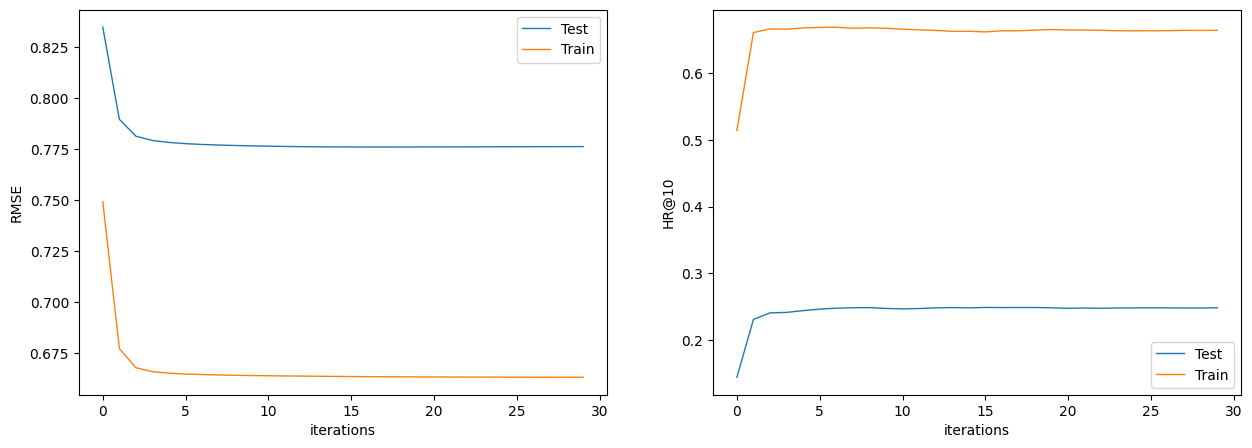

Train RMSE after fold 2: 0.6688948918082197
Test RMSE after fold 2: 0.7355364615834806
Train HR@10 after fold 2: 0.6669848002827843
Test HR@10 after fold 2: 0.31610404147519755


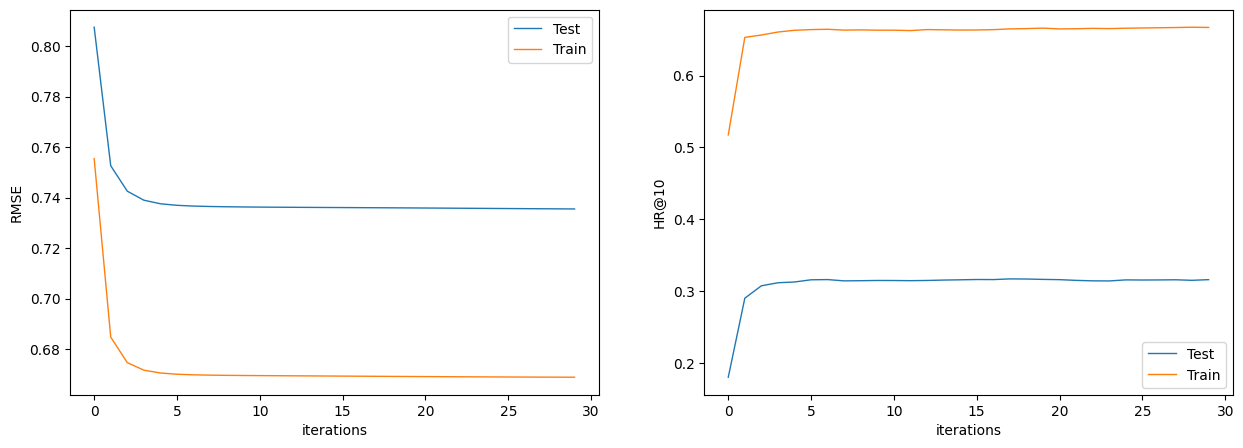

Train RMSE after fold 3: 0.6696906420961639
Test RMSE after fold 3: 0.7275122357024746
Train HR@10 after fold 3: 0.6576352067868494
Test HR@10 after fold 3: 0.38106894578262546


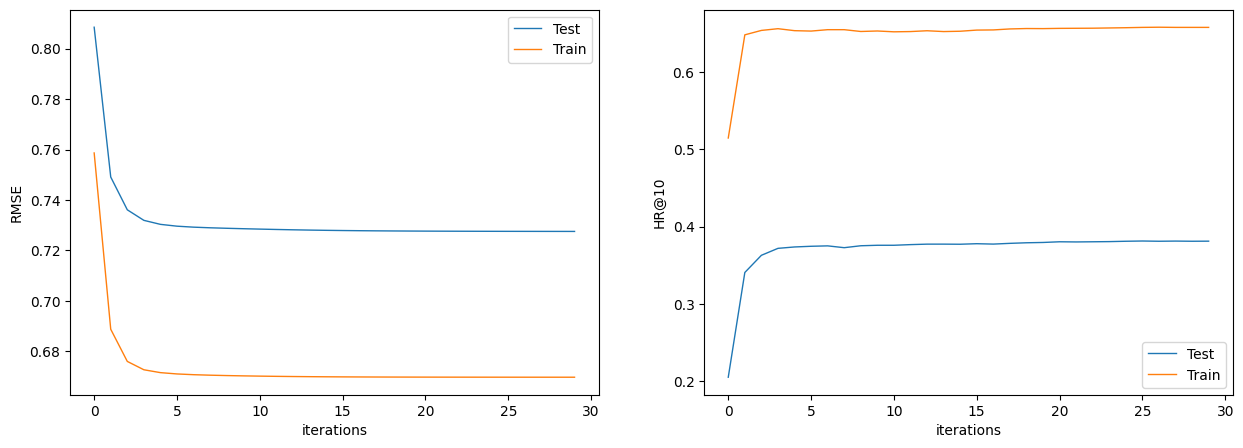

Train RMSE after fold 4: 0.6674776796387496
Test RMSE after fold 4: 0.7359518809814326
Train HR@10 after fold 4: 0.6578144725546639
Test HR@10 after fold 4: 0.39147645979565365


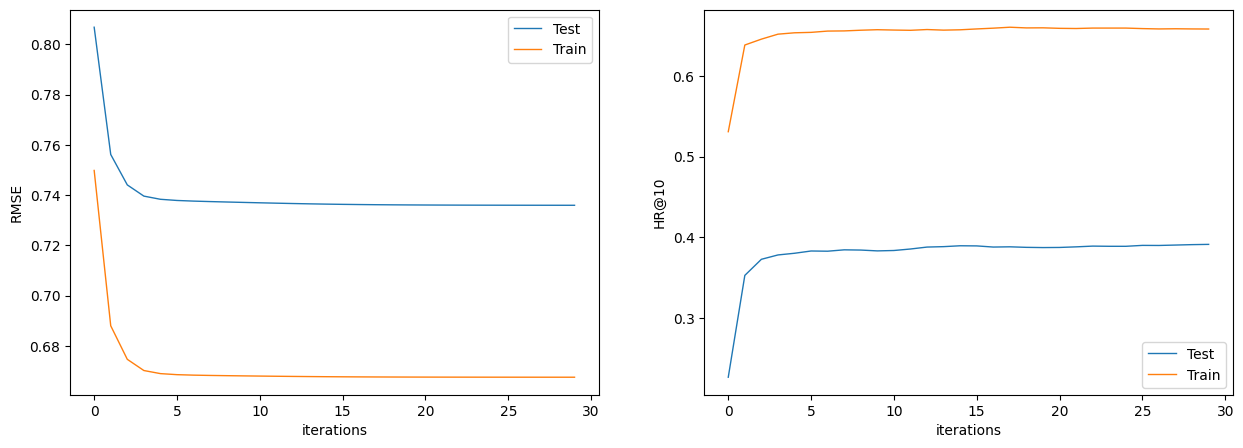

Train RMSE after fold 5: 0.6639772690064484
Test RMSE after fold 5: 0.7568562390528459
Train HR@10 after fold 5: 0.6583455368715178
Test HR@10 after fold 5: 0.38477082596912865


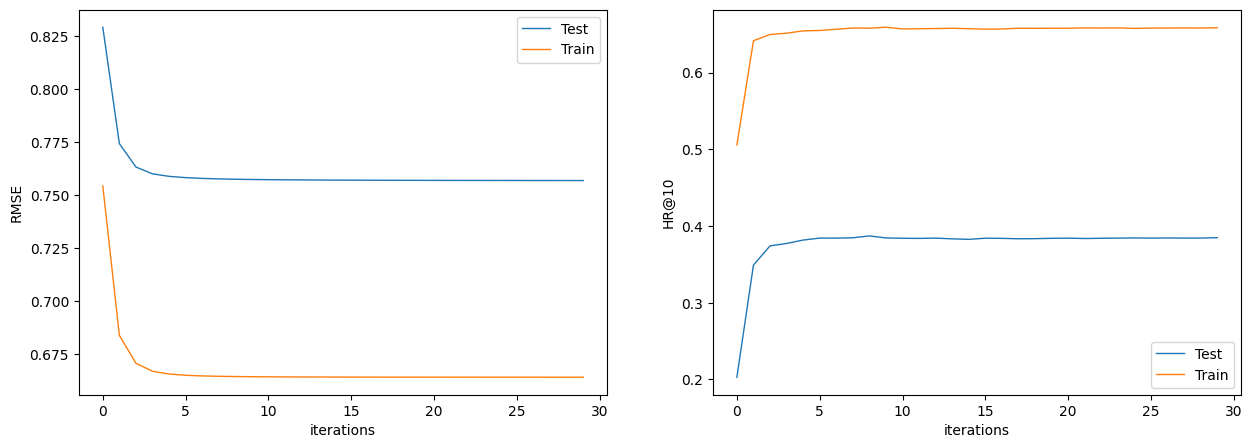

In [16]:

for fold in range(1,6):
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)

    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    train_ratings_matrix[train_ratings_matrix>0] = 1
    test_ratings_matrix[test_ratings_matrix>0] = 1
    als = MF_ALS(n_iters = 30, n_factors = 10, reg = 0.001)
    als.fit(train_ratings_matrix, test_ratings_matrix)
    
    print("Train RMSE after fold {}: {}".format(fold, als.compute_rmse(train_ratings_matrix, als.predict())))
    print("Test RMSE after fold {}: {}".format(fold, als.compute_rmse(test_ratings_matrix, als.predict())))
    print("Train HR@{} after fold {}: {}".format(als.hr_n, fold, als.compute_hr_at_n(train_ratings_matrix, als.predict(), np.zeros_like(train_ratings_matrix), als.hr_n)))
    print("Test HR@{} after fold {}: {}".format(als.hr_n, fold, als.compute_hr_at_n(test_ratings_matrix, als.predict(), train_ratings_matrix, als.hr_n)))

    plot_learning_curve(als)

In [17]:
# Rerun the algorithm based on the best hyperparameters we found so far

n_iters = [25, 30, 35, 40]
n_factors = [5, 10, 20]
reg = [0.0001, 0.001, 0.01]

best_params = grid_search(n_iters, n_factors, reg)

Testing hyperparameters:
Number of iterations:  25
Number of factors:  5
Regularization value:  0.0001
Fold:  1
RMSE:  2.9419994088510055
hr@10:  0.22882223232170204
Fold:  2
RMSE:  2.799013888147836
hr@10:  0.2902333821474862
Fold:  3
RMSE:  2.7633322496454835
hr@10:  0.34323166523590704
Fold:  4
RMSE:  2.7796161249730234
hr@10:  0.3504368025046712
Fold:  5
RMSE:  2.8687963774426795
hr@10:  0.3187101280950699
Average hr@10 for this parameter combination:  0.3062868420609673

New best found!
hr@10:  0.3062868420609673
Best hyperparameters:  {'n_iters': 25, 'n_factors': 5, 'reg': 0.0001}
Testing hyperparameters:
Number of iterations:  25
Number of factors:  5
Regularization value:  0.001
Fold:  1
RMSE:  2.9424098244240566
hr@10:  0.23060984025989337
Fold:  2
RMSE:  2.799094881899947
hr@10:  0.290129020855426
Fold:  3
RMSE:  2.7633638890778154
hr@10:  0.34295014223434156
Fold:  4
RMSE:  2.780066813235753
hr@10:  0.3526275480146107
Fold:  5
RMSE:  2.8587439991921815
hr@10:  0.347379184971

Train RMSE after fold 1: 0.6255081148684314
Test RMSE after fold 1: 0.7772988697875453
Train HR@10 after fold 1: 0.7405321584271726
Test HR@10 after fold 1: 0.25455612785941567


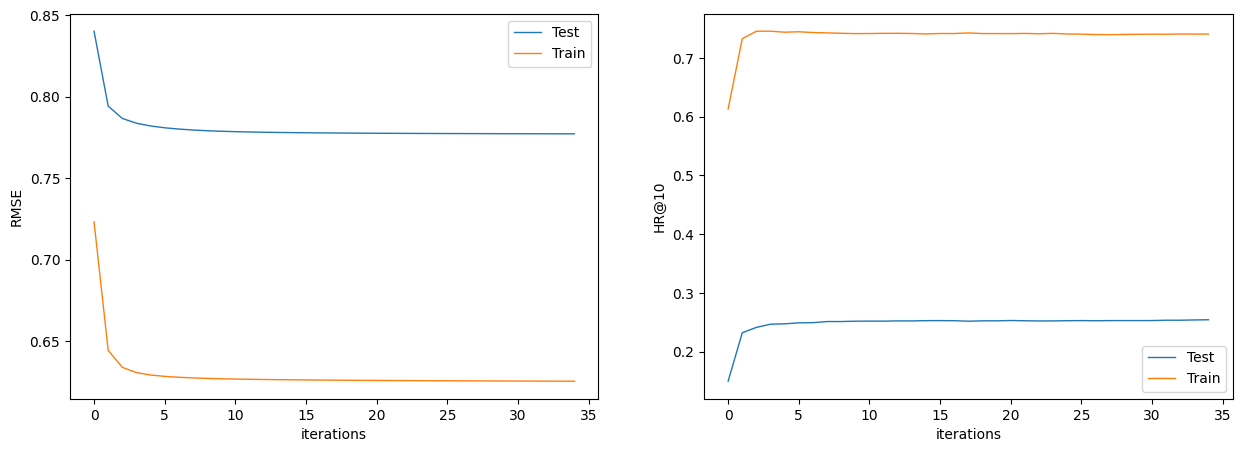

Train RMSE after fold 2: 0.6312108089627287
Test RMSE after fold 2: 0.7381875063685565
Train HR@10 after fold 2: 0.744703664427947
Test HR@10 after fold 2: 0.32560470635762306


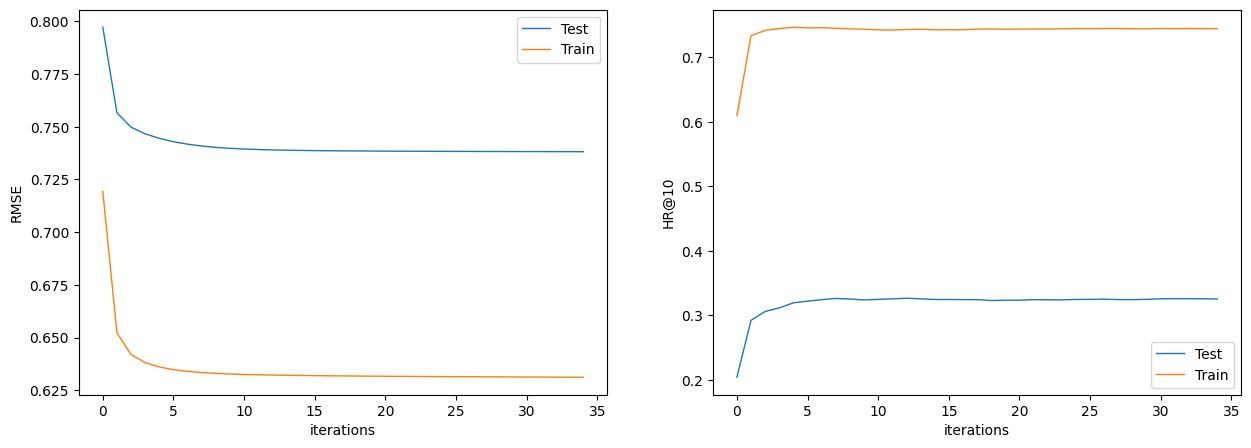

Train RMSE after fold 3: 0.6325660224645525
Test RMSE after fold 3: 0.7327593634178874
Train HR@10 after fold 3: 0.7414103923647918
Test HR@10 after fold 3: 0.3852673837297377


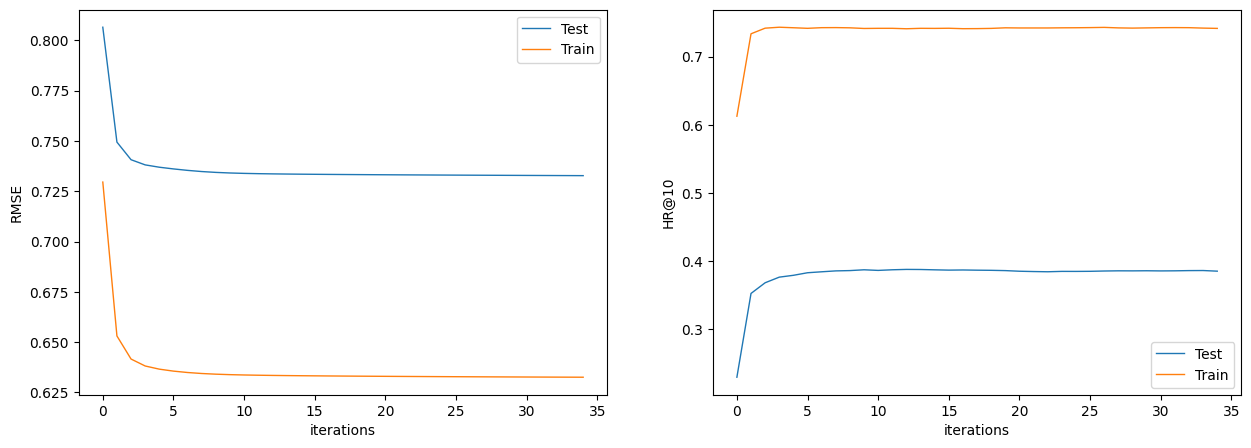

Train RMSE after fold 4: 0.6299443281104081
Test RMSE after fold 4: 0.7374895706606643
Train HR@10 after fold 4: 0.7379677321617922
Test HR@10 after fold 4: 0.39874808530694017


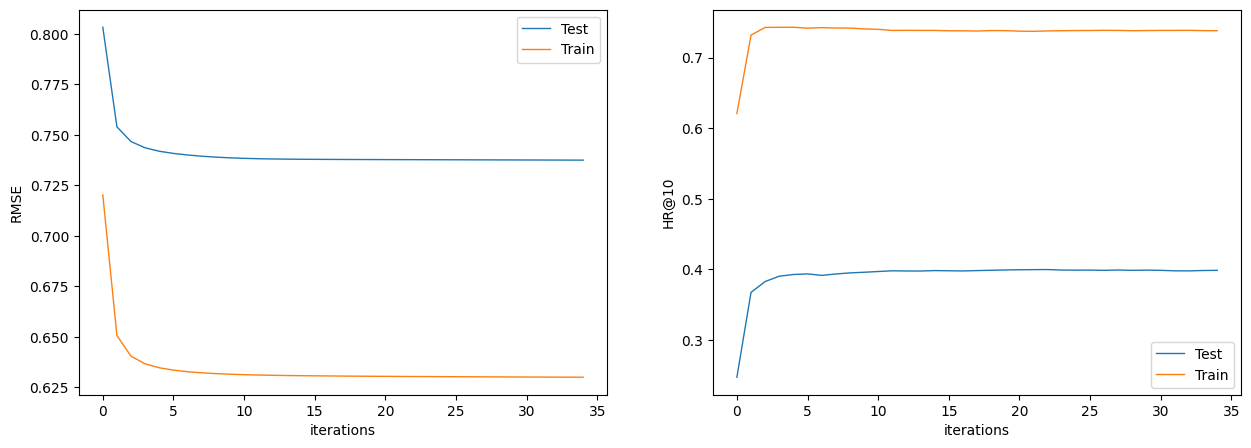

Train RMSE after fold 5: 0.6265363676850881
Test RMSE after fold 5: 0.7572297591698208
Train HR@10 after fold 5: 0.7328077395680784
Test HR@10 after fold 5: 0.3958874076318401


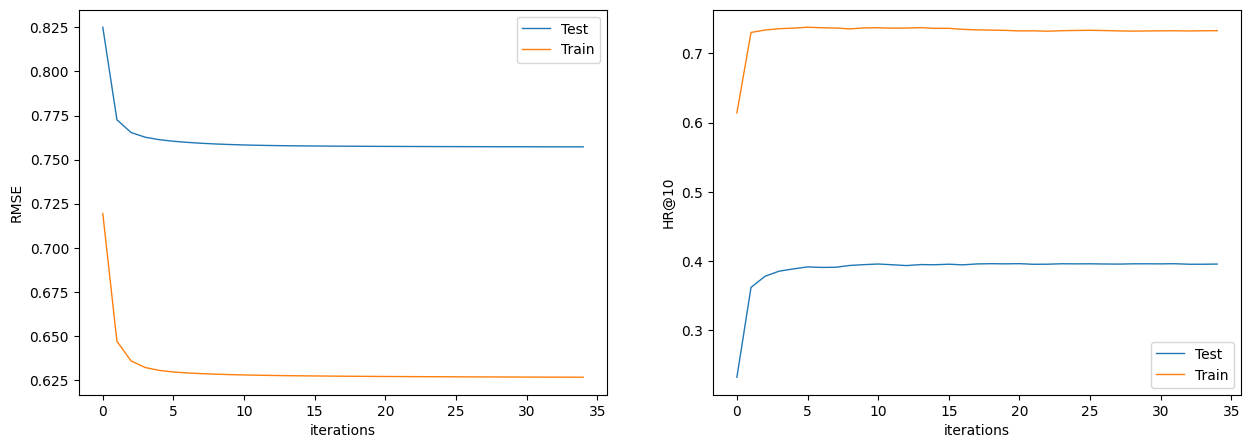

In [18]:

for fold in range(1,6):
    train = pd.read_csv('ml-100k/u{}.base'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
    test = pd.read_csv('ml-100k/u{}.test'.format(fold), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)

    train_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    test_ratings_matrix = np.array(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(1,943+1)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1,1682+1)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
    train_ratings_matrix[train_ratings_matrix>0] = 1
    test_ratings_matrix[test_ratings_matrix>0] = 1
    als = MF_ALS(n_iters = 35, n_factors = 20, reg = 0.01)
    als.fit(train_ratings_matrix, test_ratings_matrix)
    
    print("Train RMSE after fold {}: {}".format(fold, als.compute_rmse(train_ratings_matrix, als.predict())))
    print("Test RMSE after fold {}: {}".format(fold, als.compute_rmse(test_ratings_matrix, als.predict())))
    print("Train HR@{} after fold {}: {}".format(als.hr_n, fold, als.compute_hr_at_n(train_ratings_matrix, als.predict(), np.zeros_like(train_ratings_matrix), als.hr_n)))
    print("Test HR@{} after fold {}: {}".format(als.hr_n, fold, als.compute_hr_at_n(test_ratings_matrix, als.predict(), train_ratings_matrix, als.hr_n)))

    plot_learning_curve(als)